<a id=top-page></a>
# `pykitPIV` demo: Synthetic PIV of a Taylor-Green vortex

In this Jupyter notebook, we generate a Taylor-Green vortex flow.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate Taylor-Green vortex velocity field</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import cmcrameri.cm as cmc
import matplotlib.animation as animation
from pykitPIV import Particle, FlowField, Motion, Image
from pykitPIV import compute_divergence, compute_q_criterion, compute_rate_of_rotation_tensor, compute_rate_of_strain_tensor
import matplotlib.pyplot as plt

2025-08-07 14:05:36.737044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
n_images = 1
image_size = (256, 256)
size_buffer = 120
origin = 'lower'
figsize = (6,6)

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

In [4]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=2,
                     distances=(1,2),
                     densities=0.3,
                     diameter_std=0.1,
                     seeding_mode='random', 
                     random_seed=100)

In [5]:
image = Image(random_seed=100)

In [6]:
image.add_particles(particles)

<a id=generate-velocity-field></a>
***

## Generate Taylor-Green vortex velocity field

[Go to the top](#top-page)

In [7]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      time_separation=1,
                      random_seed=100)

In [8]:
flowfield.generate_taylor_green_vortex_velocity_field(k=0.011,
                                                      imposed_origin=(0,0),
                                                      displacement=(2,2))

In [9]:
image.add_flowfield(flowfield)

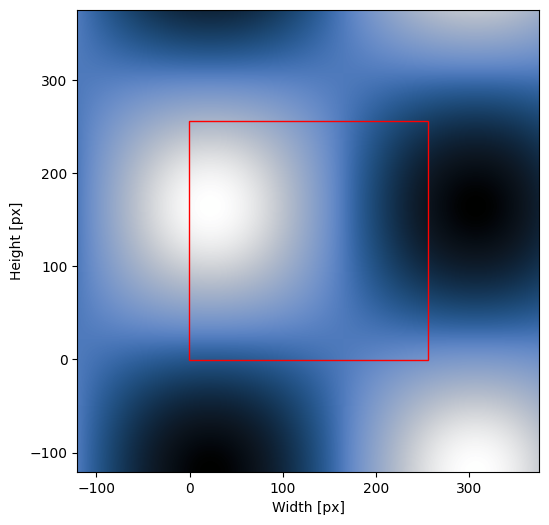

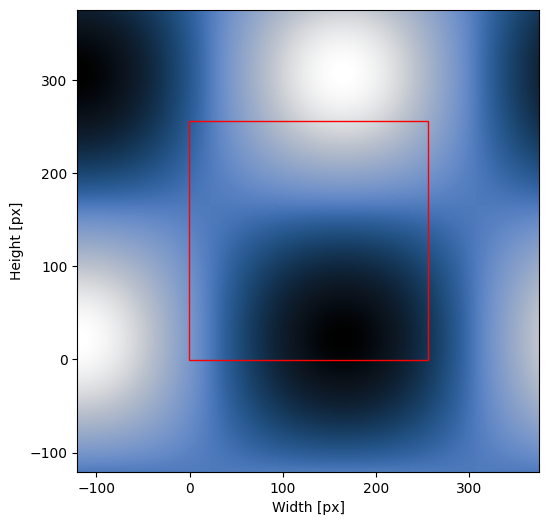

In [10]:
image.plot_field(0,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap=cmc.oslo_r,
                 origin=origin,
                 figsize=figsize);

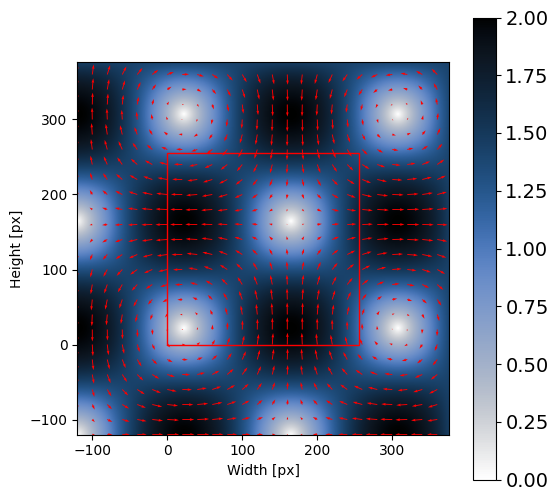

In [11]:
image.plot_field_magnitude(0,
                           with_buffer=True,
                           add_quiver=True,
                           quiver_step=20,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           cmap=cmc.oslo_r,
                           figsize=figsize);

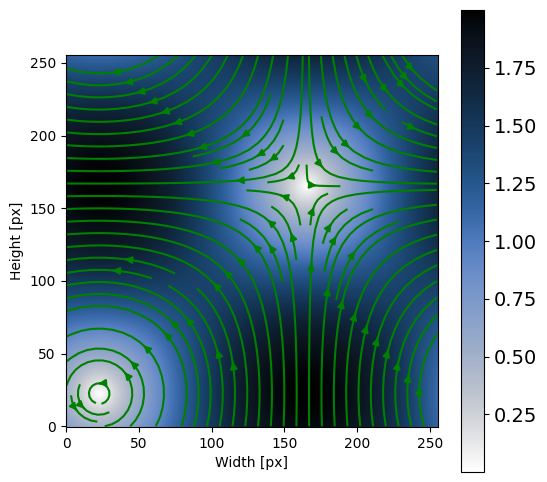

In [12]:
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_streamplot=True,
                           streamplot_density=1,
                           streamplot_color='g',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           cmap=cmc.oslo_r,
                           figsize=figsize);

We compute the divergence of this velocity field:

In [13]:
div = compute_divergence(flowfield.velocity_field)

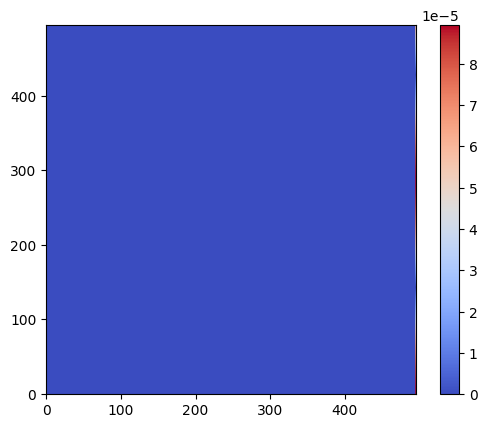

In [14]:
plt.imshow(np.abs(div[0,:,:]), cmap='coolwarm', origin='lower')
plt.colorbar();

We can also compute the Q-criterion of this velocity field:

In [15]:
Q = compute_q_criterion(flowfield.velocity_field)

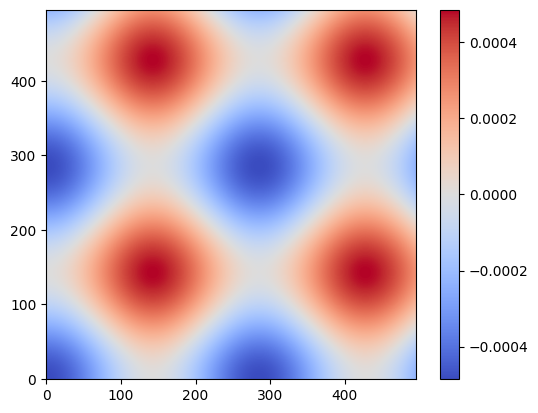

In [16]:
plt.imshow(Q[0,:,:], cmap='coolwarm', origin='lower')
plt.colorbar();

We compute the components of the rate-of-strain tensor:

In [17]:
S_11, S_22, S_12 = compute_rate_of_strain_tensor(vector_field=flowfield.velocity_field)

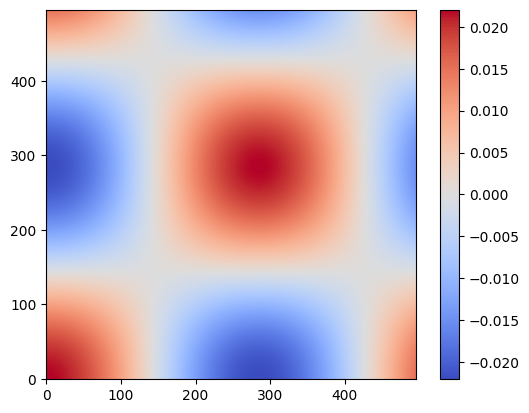

In [18]:
plt.imshow(S_11[0,:,:], cmap='coolwarm', origin='lower')
plt.colorbar()

We compute the components of the rate-of-rotation (vorticity) tensor:

In [19]:
omega_12, omega_21 = compute_rate_of_rotation_tensor(vector_field=flowfield.velocity_field)

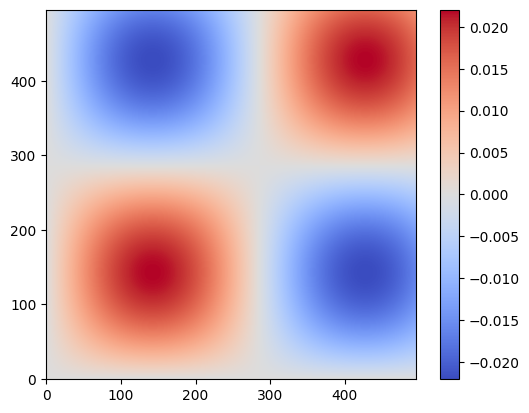

In [20]:
plt.imshow(omega_12[0,:,:], cmap='coolwarm', origin='lower')
plt.colorbar();

***

## Perform virtual PIV of a Taylor-Green vortex

In [21]:
title = 'Taylor-Green vortex'

<a id=generate-particles></a>

### Generate particles for the compressible flow

[Go to the top](#top-page)

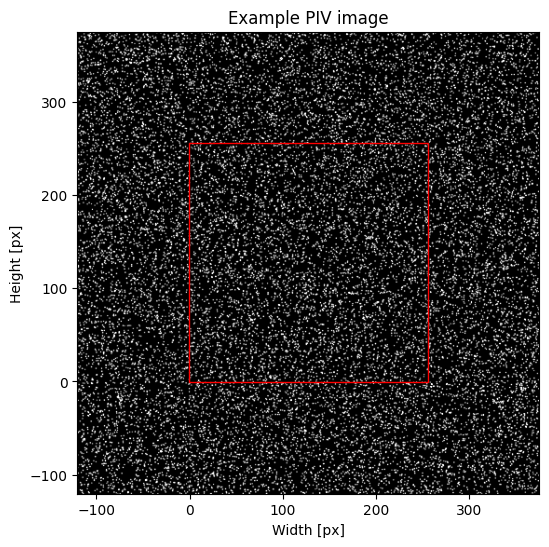

In [22]:
image.add_reflected_light(exposures=0.99,
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/8)

image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize);

<a id=add-movement></a>

### Add movement to particles

[Go to the top](#top-page)

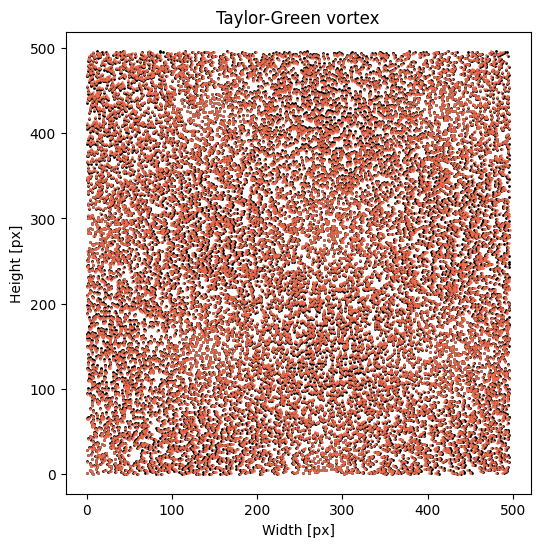

In [23]:
motion = Motion(particles, 
                flowfield, 
                particle_loss=0, 
                particle_gain=0)

motion.forward_euler(n_steps=10)

motion.plot_particle_motion(0,
                            s=1,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title=title,
                            figsize=figsize);

image.add_motion(motion)

image.add_reflected_light(exposures=0.99,
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

In [24]:
time_separation = 0.4

In [25]:
current_I2 = [image.remove_buffers(image.images_I2)]

for i in range(0,60):

    print('t = ' + str(round((i+2)*time_separation,1)) + 's')

    new_images_I1 = motion.particle_coordinates_I2
    
    particles.upload_particle_coordinates(new_images_I1)
    
    motion = Motion(particles, 
                    flowfield, 
                    particle_loss=0, 
                    particle_gain=0)
    
    motion.runge_kutta_4th(n_steps=4)
    
    image.add_motion(motion)
    image.add_reflected_light(exposures=0.99,
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/8)

    current_I2.append(image.remove_buffers(image.images_I2))

t = 0.8s
t = 1.2s
t = 1.6s
t = 2.0s
t = 2.4s
t = 2.8s
t = 3.2s
t = 3.6s
t = 4.0s
t = 4.4s
t = 4.8s
t = 5.2s
t = 5.6s
t = 6.0s
t = 6.4s
t = 6.8s
t = 7.2s
t = 7.6s
t = 8.0s
t = 8.4s
t = 8.8s
t = 9.2s
t = 9.6s
t = 10.0s
t = 10.4s
t = 10.8s
t = 11.2s
t = 11.6s
t = 12.0s
t = 12.4s
t = 12.8s
t = 13.2s
t = 13.6s
t = 14.0s
t = 14.4s
t = 14.8s
t = 15.2s
t = 15.6s
t = 16.0s
t = 16.4s
t = 16.8s
t = 17.2s
t = 17.6s
t = 18.0s
t = 18.4s
t = 18.8s
t = 19.2s
t = 19.6s
t = 20.0s
t = 20.4s
t = 20.8s
t = 21.2s
t = 21.6s
t = 22.0s
t = 22.4s
t = 22.8s
t = 23.2s
t = 23.6s
t = 24.0s
t = 24.4s


<a id=animate></a>

### Animate

[Go to the top](#top-page)

In [26]:
def animate_evolution(imagelist):

    fig = plt.figure(figsize=(6,6))

    im = plt.imshow(imagelist[0][0,0,:,:], cmap='Greys_r', origin=origin, animated=True)

    plt.title(title)
    
    def updatefig(j):

        im.set_array(imagelist[j][0,0,:,:])

        return [im]
    
    anim = animation.FuncAnimation(fig, updatefig, frames=range(len(current_I2)), interval=1, blit=True)
    
    anim.save('../docs/images/animate-taylor-green-vortex-PIV.gif', fps=20, bitrate=-1, dpi=150, savefig_kwargs={'bbox_inches' : 'tight'})
    
    return anim

MovieWriter ffmpeg unavailable; using Pillow instead.


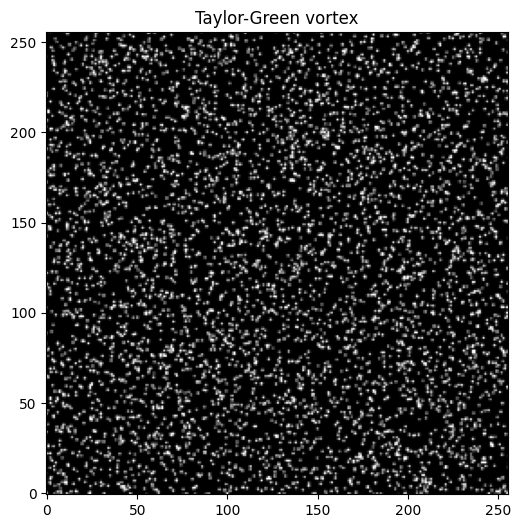

In [27]:
animate_evolution(current_I2);

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)